# Automatic Streaming Highlights

This Notebook contains my experiments and my custom implementation using the code from Zulko's Automatic Soccer Highlights [[1]](http://zulko.github.io/blog/2014/07/04/automatic-soccer-highlights-compilations-with-python/) in order to use it for my gaming streamings and my new project **Automatic Gaming Tools** which is a subtask of **Automatic Video Uploader**. 

Similar to Zulko's implementation, I would like to make a video summary of a previously saved streaming video game, using the fact that myself and my friend (in the video that we recorded) usually scream, tend to be louder when something interesting happens. By this explained fact, in this project I select **as a metric for my gaming highlights the noisiness** of my clips in order for them to be put in the video. In other words, the loudest moments of the streaming will be the most considered to be put in the summary, which is also the same metric that is used in the Zulko's algorithm.

At the moment, I'm also working on another metrics for **Automatic Gaming/Streaming Highlights** based on specific in-game sounds that specify a possible highlight as a multikill, objective complete in Halo Infinite using **speech recognition** and the text recognition of the same events such as reading **DOUBLE KILL**, **OBJECTIVE COMPLETE** directly from the video input using **text recognition**. The repo for that project can be found [here](https://github.com/spolo96/gaming-text-speech-recognition).

With all of this said, let's get started.

In [2]:
import os
import matplotlib.pyplot as plt
import time
import numpy as np # for numerical operations
from moviepy.editor import VideoFileClip, concatenate

print(os.getcwd())

C:\Users\User\Documents\Python_Scripts\Automatic_Streaming_Highlights


Get the path of the videos that we would like to perform the automatic highlight:

In [4]:
os.chdir("/mnt/c/Users/User/Videos/VODs/Fall_Guys/Streaming2GottaGoFast") # Path of video directory
curDir = os.getcwd()
print(curDir)

/mnt/c/Users/User/Videos/VODs/Fall_Guys/Streaming2GottaGoFast


In [5]:
# Check videos in the path
!ls

streaming2p1.mp4       streaming2p2_80percent_cuts.mp4	volumesPlot.png
streaming2p1_cuts.mp4  streaming2p2_cuts.mp4
streaming2p2.mp4       streaming2p3.mp4


In [1]:
def showTimeGraph(x1,y1,title): 
    fig, ax = plt.subplots() # Create a figure and an axes.
    ax.plot(x1,y1) # Plot some data on the axes.

    ax.set(xlabel='Time (seconds)', ylabel='Volume',
        title=title)
    ax.grid()
    #ax.legend()  # Add a legend.

    fig.savefig("volumesPlot.png")
    plt.show()
    return 1

The next lines open the video file with Python (which in my case  and compute the audio volume of each second of the match:

In [7]:
start = time.time()

clip = VideoFileClip("streaming2p3.mp4")
cut = lambda i: clip.audio.subclip(i,i+1).to_soundarray(fps=22000)
volume = lambda array: np.sqrt(((1.0*array)**2).mean())
volumes = [volume(cut(i)) for i in range(0,int(clip.duration-1))]

end = time.time()

# Time taken to perform operation
print(end - start)

6.1058220863342285


In [8]:
print(len(volumes))

a_list = list(range(0, len(volumes)))

#print(a_list)

2410


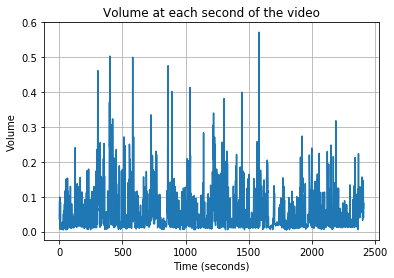

1

In [9]:
showTimeGraph(a_list, volumes, 'Volume at each second of the video')

In [10]:
averaged_volumes = np.array([sum(volumes[i:i+10])/10
                             for i in range(len(volumes)-10)])

In [11]:
a_list = list(range(0, len(volumes)-10))

In [12]:
print(len(a_list))

2400


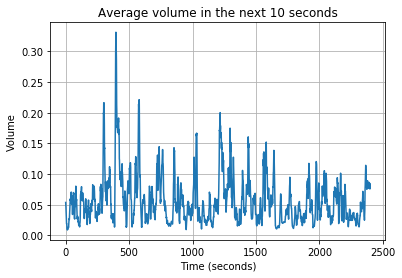

1

In [13]:
showTimeGraph(a_list, averaged_volumes, 'Average volume in the next 10 seconds')

In [14]:
increases = np.diff(averaged_volumes)[:-1]>=0
decreases = np.diff(averaged_volumes)[1:]<=0
peaks_times = (increases * decreases).nonzero()[0]
peaks_vols = averaged_volumes[peaks_times]
peaks_times = peaks_times[peaks_vols>np.percentile(peaks_vols,90)]

In [15]:
final_times=[peaks_times[0]]
for t in peaks_times:
    if (t - final_times[-1]) < 60:
        if averaged_volumes[t] > averaged_volumes[final_times[-1]]:
            final_times[-1] = t
    else:
        final_times.append(t)

In [16]:
print(final_times)

[302, 395, 578, 763, 853, 1031, 1217, 1295, 1438, 1580, 1640, 1974]


In [17]:
start = time.time()
final = concatenate([clip.subclip(max(t-5,0),min(t+5, clip.duration))
                     for t in final_times])
final.to_videofile('streaming2p3_cuts.mp4') # Low quality is the default
end = time.time()
print("Time of the algorithm: ")
print(end - start)

[MoviePy] >>>> Building video streaming2p3_cuts.mp4
[MoviePy] Writing audio in streaming2p3_cutsTEMP_MPY_wvf_snd.mp3


100%|██████████| 2646/2646 [00:03<00:00, 799.91it/s]

[MoviePy] Done.
[MoviePy] Writing video streaming2p3_cuts.mp4



100%|█████████▉| 3600/3601 [00:25<00:00, 139.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: streaming2p3_cuts.mp4 

Time of the algorithm: 
32.53192472457886


# References

[[1] Automatic Soccer Highlights Compilations With Python](http://zulko.github.io/blog/2014/07/04/automatic-soccer-highlights-compilations-with-python/)